In [171]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import os
import numpy as np
ROOT_DIR = "../../"

def parse_results(results_file: str):
    with open(results_file, 'r') as f:
        lines = f.readlines()

    run_times = {}  
    compile_times = {}   #indexed by 2 strings: benchmark name and optimisation name
    lines_of_code = {}  #does not include GFortran
    current_benchmark = None
    current_optimisation = None

    index = 0  # Initialize an index to track the current line

    while index < len(lines):
        line = lines[index]
        if line.startswith("Benchmark:"):
            current_benchmark = line.split(":")[1].strip()

            if current_benchmark not in run_times:
                run_times[current_benchmark] = {}
            if current_benchmark not in compile_times:
                compile_times[current_benchmark] = {}
            if current_benchmark not in lines_of_code:
                lines_of_code[current_benchmark] = {}
           
        elif line.startswith("Optimisation:"):
            parts = line.split(":")
            if len(parts) > 1:
                current_optimisation = parts[1].strip()#.lstrip('-')
                if current_optimisation == "":
                    current_optimisation = "None"
                if current_optimisation == "-iterCSE-CP -iterPRE-CP -const -DCE -simplify":
                    current_optimisation = "All"
                
            run_times[current_benchmark][current_optimisation] = []     #should not exist yet - add empty list
            compile_times[current_benchmark][current_optimisation] = []

        elif line.startswith("Lines of code:"):
            index += 1  # Move to the next line after "Lines of code:"
            loc = int(lines[index].strip())
            lines_of_code[current_benchmark][current_optimisation] = loc
            continue  # Skip the rest of the loop to avoid incrementing index again

        elif line.startswith("Run times:"):
            index += 1  # Move to the next line after "Run times:"
            # Start reading run times
            while index < len(lines) and not lines[index].startswith("Compile times:"):
                run_times[current_benchmark][current_optimisation].append(float(lines[index].strip()))
                index += 1  # Advance the index
            continue  # Skip the rest of the loop to avoid incrementing index again
        elif line.startswith("Compile times:"):
            index += 1  # Move to the next line after "Compile times:"
            # Start reading compile times
            while index < len(lines) and not lines[index].startswith("----"):
                compile_times[current_benchmark][current_optimisation].append(float(lines[index].strip()))
                index += 1  # Advance the index
            continue  # Skip the rest of the loop to avoid incrementing index again
        index += 1  # Move to the next line for the main loop

    # Handle cases where run_times or compile_times might be empty
    return run_times, compile_times, lines_of_code

def get_average_times(times_dict: dict):
    for benchmark in times_dict:
        for optimisation in times_dict[benchmark]:
            times_dict[benchmark][optimisation] = sum(times_dict[benchmark][optimisation]) / len(times_dict[benchmark][optimisation])
    return times_dict

# def draw_bar_chart(times_dict: dict):
#     for benchmark in times_dict:
#         for optimisation in times_dict[benchmark]:
#             plt.bar(optimisation, times_dict[benchmark][optimisation])
#     plt.show()


#plots the average run and compile times for each benchmark
def draw_bar_chart(run_times_dict: dict, compile_times_dict: dict, save_plot_path: str):
    benchmarks = list(run_times_dict.keys())
    num_benchmarks = len(benchmarks)
    
    # Create a figure with subplots
    fig, axs = plt.subplots(num_benchmarks, 2, figsize=(12, 5 * num_benchmarks))
    
    for i, benchmark in enumerate(benchmarks):
        # Get the correct axes based on number of benchmarks
        if num_benchmarks == 1:
            ax_run = axs[0]
            ax_compile = axs[1]
        else:
            ax_run = axs[i, 0]
            ax_compile = axs[i, 1]

        # Plot run times
        optimisations = list(run_times_dict[benchmark].keys())
        run_times = list(run_times_dict[benchmark].values())

        # colors = cm.mako(np.linspace(0.2, 0.8, len(optimisations)))  # Generate colors based on the number of optimisations
        colors = sns.color_palette("mako", len(optimisations))
        ax_run.bar(optimisations, run_times, color=colors)
        ax_run.set_title(f'Run Times for {benchmark}')
        ax_run.set_ylabel('Time (s)')
        ax_run.set_xlabel('Optimisation')
        ax_run.set_ylim(bottom=0)  # Set the lower limit to 0
        ax_run.set_ylim(top=max(run_times) * 1.1)  # Set the upper limit to 10% above the max run time
        ax_run.tick_params(axis='x', rotation=45)
        
        # Plot compile times
        
        compile_times = list(compile_times_dict[benchmark].values())
        ax_compile.bar(optimisations, compile_times, color=colors)
        ax_compile.set_title(f'Compile Times for {benchmark}')
        ax_compile.set_ylabel('Time (s)')
        ax_compile.set_xlabel('Optimisation')
        ax_compile.set_ylim(bottom=0)  # Set the lower limit to 0
        ax_compile.set_ylim(top=max(compile_times) * 1.1)  # Set the upper limit to 10% above the max compile time
        ax_compile.tick_params(axis='x', rotation=45)
    plt.tight_layout()

    # Save the figure if a save path is provided
    if save_plot_path:
        plt.savefig(save_plot_path, dpi=300, bbox_inches='tight')
    

    plt.show()


def plot_compile_times(all_compile_times: dict, save_dir: str):
    benchmarks = list(all_compile_times.keys())

    for benchmark in benchmarks:
        plt.figure(figsize=(6, 6))
        opt_compile_times = all_compile_times[benchmark]
        optimisations = list(opt_compile_times.keys())
        compile_times = list(opt_compile_times.values())

        median_times = np.median(compile_times, axis=1)
        iqr_low = median_times - np.percentile(compile_times, 25, axis=1)  # Q1 - Median
        iqr_high = np.percentile(compile_times, 75, axis=1) - median_times  # Q3 - Median
        yerr = [iqr_low, iqr_high]

        # colors = sns.color_palette("mako", len(optimisations))
        colors = []
        for opt in optimisations:
            if opt == 'GFortran':
                colors.append('#992D7F')  # purple
            else:
                colors.append(sns.color_palette("mako", len(optimisations))[optimisations.index(opt)])

        plt.bar(optimisations, median_times, yerr=yerr, capsize=5, color=colors)
        xticks = plt.xticks(rotation=90, ha='center')
        xticks[1][0].set_color(colors[0])

        plt.ylabel('Compile Time (ms)', labelpad=10)
        plt.xlabel('Compiler Configuration')
        # plt.title(f'{benchmark}')
        plt.tight_layout()

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f'compile_times_{benchmark}.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()

def plot_run_times(all_run_times: dict, save_dir: str):
    benchmarks = list(all_run_times.keys())

    for benchmark in benchmarks:
        plt.figure(figsize=(6, 6))
        opt_run_times = all_run_times[benchmark]
        optimisations = list(opt_run_times.keys())
        run_times = list(opt_run_times.values())

        median_times = np.median(run_times, axis=1)
        iqr_low = median_times - np.percentile(run_times, 25, axis=1)  # Q1 - Median
        iqr_high = np.percentile(run_times, 75, axis=1) - median_times  # Q3 - Median
        yerr = [iqr_low, iqr_high]

        colors = []
        for opt in optimisations:
            if opt == 'GFortran':
                colors.append('#992D7F')  # purple
            else:
                colors.append(sns.color_palette("mako", len(optimisations))[optimisations.index(opt)])

        plt.bar(optimisations, median_times, yerr=yerr, capsize=5, color=colors)
        xticks = plt.xticks(rotation=90, ha='center')
        xticks[1][0].set_color(colors[0])    #set Gfortran colour to match the purple
     
        plt.ylabel('Run Time (ms)', labelpad=10)
        plt.xlabel('Compiler Configuration')
        # plt.title(f'{benchmark}')
        plt.tight_layout()

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f'run_times_{benchmark}.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()

# def plot_lines_of_code(lines_of_code: dict, save_dir: str):
#     benchmarks = list(lines_of_code.keys())

#     for benchmark in benchmarks:
#         plt.figure(figsize=(6, 6))
#         opt_lines_of_code = lines_of_code[benchmark]
#         optimisations = list(opt_lines_of_code.keys())
#         lines_of_code = list(opt_lines_of_code.values())

#         #does not have ranges, just a fixed value
#         colors = sns.color_palette("mako", len(optimisations))
#         plt.bar(optimisations, lines_of_code, color=colors)
#         plt.xticks(rotation=90, ha='center')
#         plt.ylabel('Lines of Code')
#         plt.title(f'{benchmark}')
#         plt.tight_layout()

#         if save_dir:
#             os.makedirs(save_dir, exist_ok=True)
#             save_path = os.path.join(save_dir, f'lines_of_code_{benchmark}.png')
#             plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
#         plt.show()
        

def plot_lines_of_code(lines_of_code: dict, save_dir: str):
    benchmarks = list(lines_of_code.keys())

    for benchmark in benchmarks:
        plt.figure(figsize=(6, 6))
        opt_lines_of_code = lines_of_code[benchmark]
        optimisations = list(opt_lines_of_code.keys())
        loc_values = list(opt_lines_of_code.values())
        
        colors = sns.color_palette("mako", len(optimisations))
        
        # Plot just dots (no stems)
        plt.scatter(optimisations, loc_values, color=colors, s=100)
        
        # Add value labels
        for i, value in enumerate(loc_values):
            plt.text(i, value + (max(loc_values)*1.1-min(loc_values)*0.9)*0.025, f'{value}',
                     ha='center', va='bottom', fontsize=9)
        
        # Adjust y-axis to zoom in (remove padding and focus on data range)
        plt.ylim(min(loc_values) * 0.9, max(loc_values) * 1.1)  # 10% padding
        
        plt.xticks(rotation=90, ha='center')
        plt.ylabel('Lines of Code', labelpad=10)
        plt.xlabel('Compiler Optimisation')
        # plt.title(f'{benchmark}')
        plt.tight_layout()

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f'lines_of_code_{benchmark}.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()

        
     
        

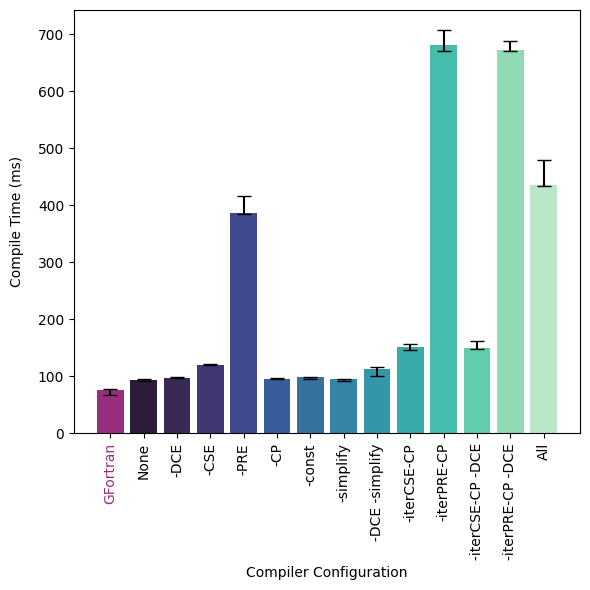

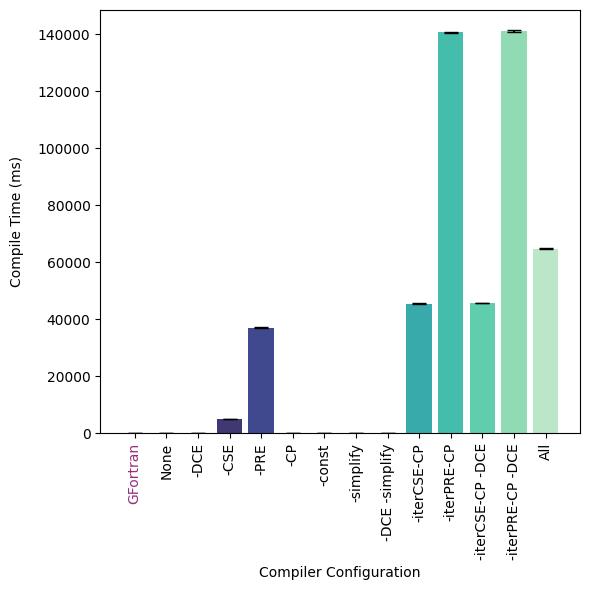

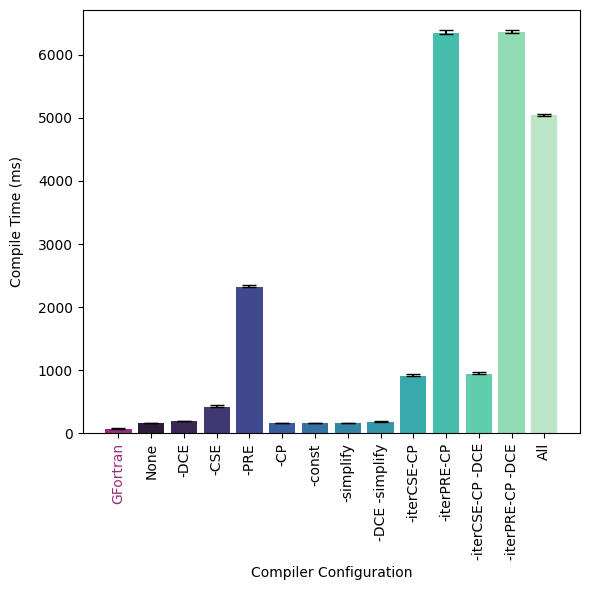

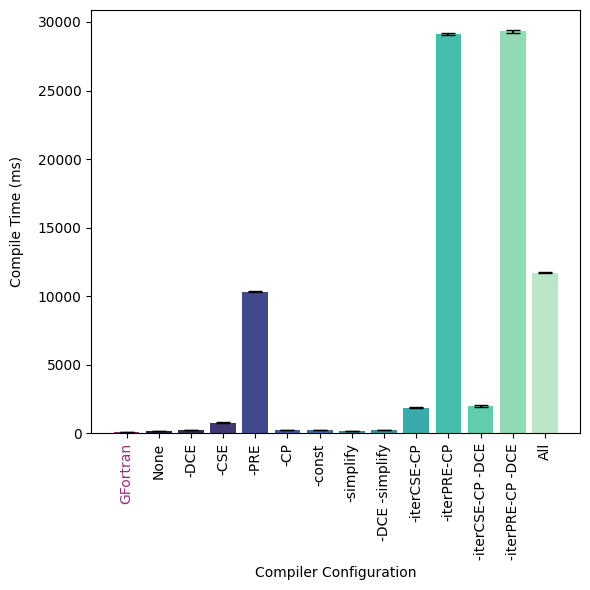

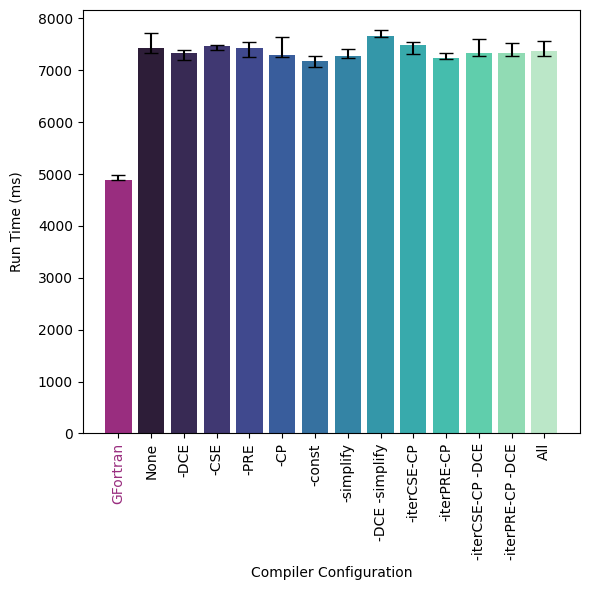

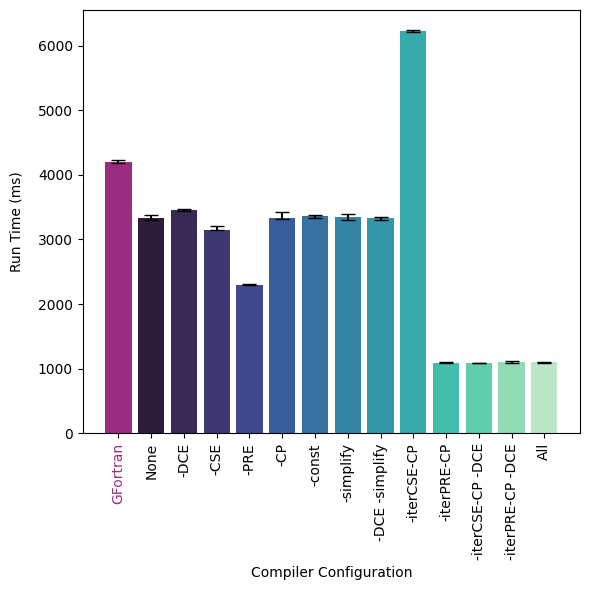

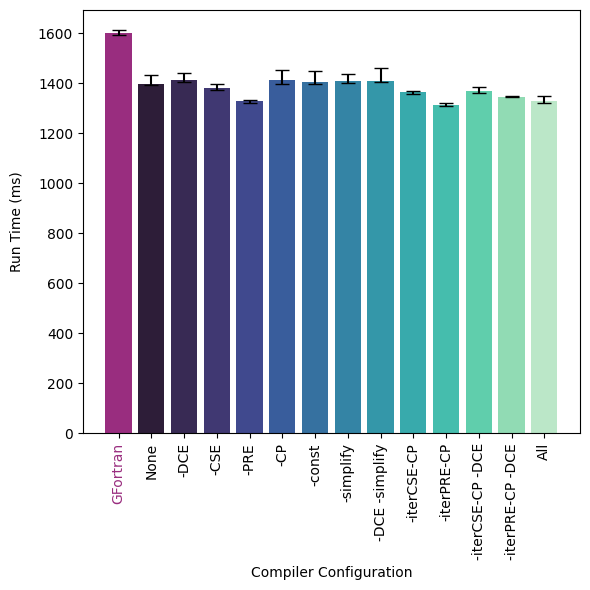

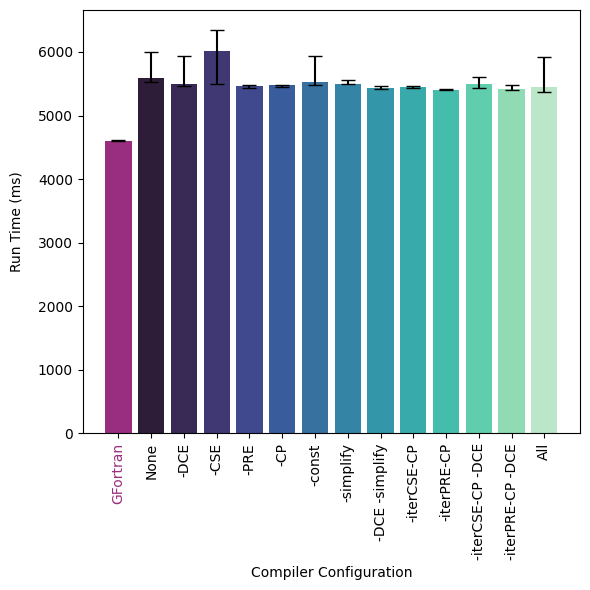

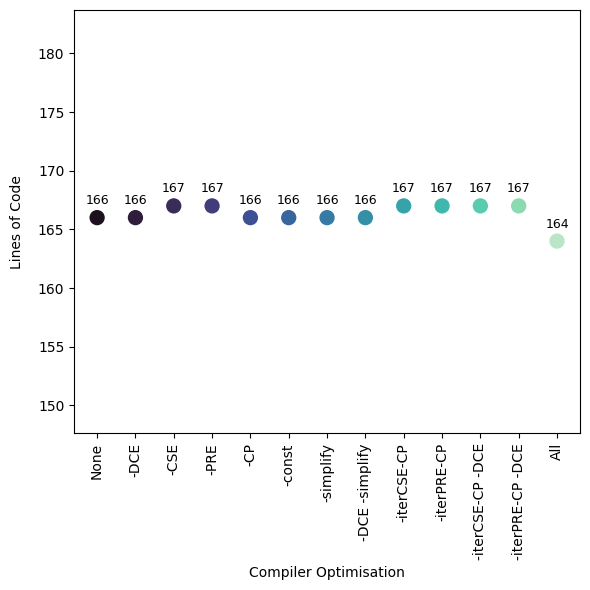

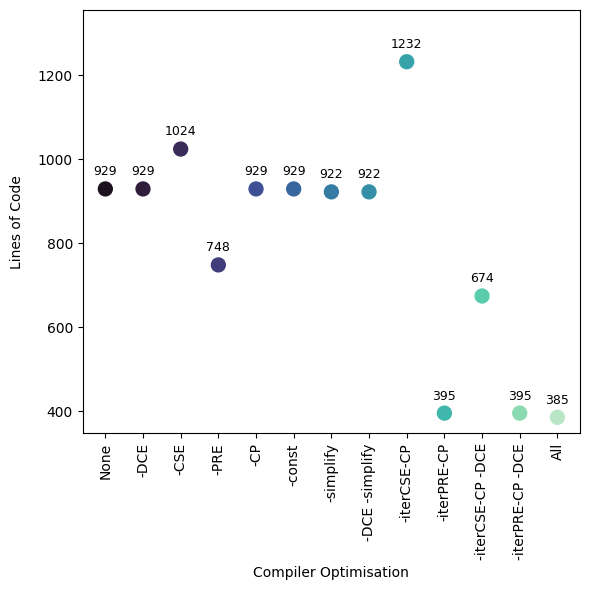

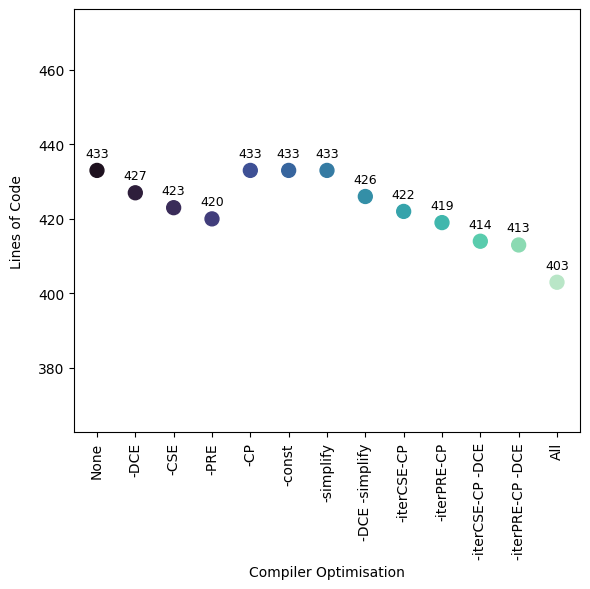

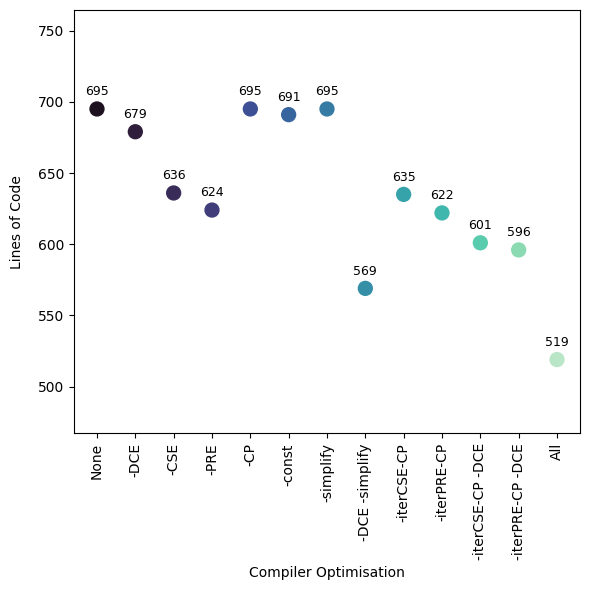

In [172]:
def main():
    experiment_number = 41
    results_file = ROOT_DIR + "scripts/benchmark/results/exp" + str(experiment_number) + f"/benchmark_results_{str(experiment_number)}.txt"
    save_dir = ROOT_DIR + "scripts/benchmark/results/exp" + str(experiment_number) 
    save_plot_path = save_dir+ f"/benchmark_plot_{str(experiment_number)}.png"

    
    run_times, compile_times, lines_of_code = parse_results(results_file)
    # avg_run_times = get_average_times(run_times)
    # avg_compile_times = get_average_times(compile_times)
    # print(avg_run_times)
    # print(avg_compile_times)
    # draw_bar_chart(avg_run_times, avg_compile_times, save_plot_path)
    # print(compile_times)
    # print(lines_of_code)
    plot_compile_times(compile_times, save_dir+f"/compile_times2")
    plot_run_times(run_times, save_dir+f"/run_times2")
    plot_lines_of_code(lines_of_code, save_dir+f"/lines_of_code2")

    # print(lines_of_code)
    

if __name__ == "__main__":
    main()